


<div class="alert alert-info" role="alert">

 ## Travail à réaliser:

***Questions préliminaires (4 points)***

Dans le Branch-and-Bound fourni dans le notebook-exemple (⚠️ pas dans le code que vous avez modifié) :

- Quelle est la règle de séparation choisie?  
- Quelle méthode de calcul de borne supérieure est utilisée?  
- Quels sont les tests de sondabilité TA, TO, TR?  
- Quelle est la stratégie d'exploration choisie



***Rédaction (5 points)***

Rédigez une réflexion critique :
- Quels points du notebook pourraient être améliorés ?
- Faites le lien avec les notions vues lors du TD 2.
- Quelles pistes d’optimisation ou d’extension envisagez-vous ?



***Code – Amélioration (6 points)***

- Modifiez le notebook initial pour y apporter vos propres améliorations.
- Pensez à commenter votre code.


***Code – Comparaison (5 points)***

Comparez les performances du Branch-and-Bound entre :
- la version initiale du notebook,
- votre version améliorée.

Pour cela :
- utilisez un nombre suffisant d’instances et de tailles variées,
- discutez les résultats obtenus,
- indiquez si ces résultats vous semblent cohérents et justifiez vos arguments.



***Rendu attendu***

Un notebook unique contenant :
- vos réponses aux questions (sous forme de cellules Markdown),
- la rédaction,
- le code initial,
- vos améliorations avec commentaires,
- la comparaison des performances.
</div>

# TP2 — Branch-and-Bound (B&B) pour le sac à dos
<div class="alert-success">
<b>😀 Objectif :</b> Comprendre et implémenter un Branch-and-Bound complet pour le sac à dos.
</div>

## 🌳 Pourquoi le Branch-and-Bound ? 
- <b>But</b> : éviter l'énumération exhaustive (2^n feuilles, n = nb objets) en identifiant tôt les branches inutiles.   

<div class="alert-success">
<b>🧐 À retenir :</b> une <i>bonne borne</i> + une <i>bonne stratégie</i> = un arbre <i>beaucoup</i> plus petit.
</div>


Exemple du TD:

4 objets et la capacité est 10 tel que: 
- Objet 1 - valeur: 42, poids: 7
- Objet 2 - valeur: 40, poids: 4
- Objet 3 - valeur:12, poids: 3
- Objet 4 - valeur:25, poids: 5

Énumération exhaustive des $2^4 = 16$ combinaisons

| Combinaison {1,2,3,4} | Objets Inclus  | Poids Total      | Valeur Totale       | Admissible (Poids ≤ 10) ? |
| :------------------: | :-------------: | :--------------: | :-----------------: | :-----------------------: |
|        `0000`        |       {}        |        0         |          0          |          ✅ Oui           |
|        `0001`        |       {4}       |        5         |         25          |          ✅ Oui           |
|        `0010`        |       {3}       |        3         |         12          |          ✅ Oui           |
|        `0011`        |     {3, 4}      |    3 + 5 = 8     |     12 + 25 = 37    |          ✅ Oui           |
|        `0100`        |       {2}       |        4         |         40          |          ✅ Oui           |
|      **`0101`** |   **{2, 4}** |  **4 + 5 = 9** |  **40 + 25 = 65** |        **✅ Oui** |
|        `0110`        |     {2, 3}      |    4 + 3 = 7     |     40 + 12 = 52    |          ✅ Oui           |
|        `0111`        |    {2, 3, 4}    |   4 + 3 + 5 = 12   |    40+12+25 = 77    |          ❌ Non           |
|        `1000`        |       {1}       |        7         |         42          |          ✅ Oui           |
|        `1001`        |     {1, 4}      |    7 + 5 = 12    |     42 + 25 = 67    |          ❌ Non           |
|        `1010`        |     {1, 3}      |    7 + 3 = 10    |     42 + 12 = 54    |          ✅ Oui           |
|        `1011`        |    {1, 3, 4}    |   7 + 3 + 5 = 15   |    42+12+25 = 79    |          ❌ Non           |
|        `1100`        |     {1, 2}      |    7 + 4 = 11    |     42 + 40 = 82    |          ❌ Non           |
|        `1101`        |    {1, 2, 4}    |   7 + 4 + 5 = 16   |   42+40+25 = 107    |          ❌ Non           |
|        `1110`        |    {1, 2, 3}    |   7 + 4 + 3 = 14   |    42+40+12 = 94    |          ❌ Non           |
|        `1111`        |   {1, 2, 3, 4}  | 7 + 4 + 3 + 5 = 19 | 42+40+12+25 = 119 |          ❌ Non           |

## 🔗 Lien avec la programmation linéaire
- La relaxation linéaire d’un PLNE fournit une <b>borne supérieure</b> (en maximisation) 



## Stratégie Branch and Bound
<div class="alert-danger">
🧐 Important :
    
* **Calcul de Borne :** De quelle manière relâche-t-on le problème pour obtenir une borne ? 
* **Règle de Séparation :** Comment diviser le problème  ?
* **Règle d’Exploration :** Quel est le prochain nœud à explorer ?
* **Tests de Sondabilité :** Faut-il abandonner cette branche ?
  
</div>

## Dans ce notebook
I - [Initialisation et récupération des données](#Initialisation)   
II - [Tests de sondabilités TA, TO et TR basés sur le modèle linéaire](#Tests)  
III - [Règle Exploration et Séparation](#SeparationEtExploration)  
IV - [Calcul de la borne](#Borne)  
V - [Creation de l'arbre et résolution](#Arbre)  
VI - [Affichage du résultat final](#Affichage)

## Questions préliminaires

- **1) Règle de séparation** : on branche sur le premier objet pas encore fixé (ordre lexicographique : plus petit indice non présent dans `listObjs`). On crée donc 2 cas : objet pris (`x=1`) puis objet non pris (`x=0`).
- **2) Borne supérieure** : on utilise une relaxation “fractionnaire” du sac à dos. Concrètement, on trie les objets par ratio valeur/poids décroissant, puis on prend un objet restant et on en prend une fraction pour remplir la capacité (donc $x$ peut être entre 0 et 1 pour cet objet). La borne sup = somme des valeurs (avec la fraction).
- **3) Tests TA / TO / TR** :
  - **TA** : si la capacité devient négative (`capacity < 0`), le nœud est infaisable donc on coupe.
  - **TO** : si la borne sup est ≤ BestProfit, ça ne peut pas améliorer la meilleure solution trouvée → on coupe.
  - **TR** : si toutes les variables de la solution sont entières (`0` ou `1`), on a une solution réalisable ; si elle améliore `BestProfit`, on la garde.
- **4) Stratégie d’exploration** : c’est du depth-first ou parcours en profondeur : on descend dans l’arbre, et quand un nœud est coupé/terminé, on revient en arrière pour explorer la branche “frère” (on bascule le dernier `1` en `0`).

## Rédaction

### Points à ameliorer du notebook
- Il y a beaucoup de fonctions d’un coup, et on se perd vite entre “données”, “borne”, “tests” et “exploration”. Un petit schéma du déroulé aiderait.
- Les `println("TA/TO/TR")` sont utiles, mais il manque souvent le contexte (capacité restante, valeur de la borne, valeur de la meilleure solution). Un affichage qui recapitule par noeud serait plus clair.
- La mise à jour de la meilleure solution / meilleure valeur (BestProfit) peut être fragile si on se trompe (par exemple réinitialiser à 0). Ça vaut le coup de vérifier que BestProfit ne baisse jamais et que Bestsol correspond bien.

### Lien avec le TD2
- Dans le TD2, on a justement repris l’exemple du sac à dos et on a vu que le B&B dépend de 4 choix : calcul de borne supérieure, règle de séparation, stratégie d’exploration, et tests de sondabilité.
- La borne sup était calculée avec la relaxation sac à dos fractionnaire : tri par ratio décroissant, on prend les objets tant que ça rentre, puis on prend une fraction du premier objet qui ne rentre pas entièrement (ça donne une borne supérieure).
- Les tests vus au TD2 sont les mêmes idées que dans le notebook : TA si le noeud devient infaisable (capacité < 0), TO si la borne sup est ≤ meilleure valeur trouvée, et TR/TI si la solution de la relaxation est déjà entière.

### Pistes d’optimisation / extensions
- **Borne sup** : refaire le calcul de borne comme dans le TD (tri par ratio, on prend en entier tant que ça rentre, et on fractionne seulement le dernier), sa donne une borne plus propre et sérrée.
- Aussi avant de calculer la borne, on peut enlever les objets impossibles (`poids > capacité restante`) comme on l’a vu dans les exemples de Branch and Bound (ça évite de surestimer).
- **Séparation** : essayer la règle variable la plus fractionnaire (proche de 0.5) au lieu de toujours choisir le premier indice, et comparer le nombre de noeuds explorés.
- **Meilleure solution trouvée plus tôt** : garder une solution entière simple (par exemple prendre des objets par ratio tant que ça rentre) pour avoir vite une bonne valeur pour le TO.
- **Performance** : ne pas recalculer/retirer/trier les ratios à chaque noeud si ça ne change pas vu que les ratios restent les mêmes.

## I - Initialisation et récupération des données  <a name="Initialisation"></a>

### Initialisation (à faire une seule fois)

In [2]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

   Resolving package versions...
     Project No packages added to or removed from `C:\Users\babar\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\babar\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\babar\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\babar\.julia\environments\v1.12\Manifest.toml`


### Récupération des données

In [3]:
# Reads knapsack .txt instances.
function readKnaptxtInstance(filename)
    price=Int64[]
    weight=Int64[]
    KnapCap=Int64[]
    open(filename) do f
        # Iterate over the instance file 3 lines: prices, weights, capacity.
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end
        end
    end
    capacity=KnapCap[1]
    
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

## II -  Tests de sondabilités TA, TO et TR <a name="Tests"></a>

In [4]:
# Sondability test.
function testSondability(BestProfit, Bestsol, capacity, bornesup, listVals, listObjs, price)
    TA, TO, TR = false, false, false
    eps = 1e-9
    
    println("capacité restante = ", capacity, " | borne sup = ", bornesup, " | meilleure valeur = ", BestProfit)
    
    # TA infaisable
    if capacity < -eps
        TA = true
        println("TA")
        return TA, TO, TR, Bestsol, BestProfit
    end
    
    # TO : pas d'amélioration possible
    if bornesup <= BestProfit + eps
        TO = true
        println("TO")
        return TA, TO, TR, Bestsol, BestProfit
    end
    
    # TR : si tout est déjà entier (0/1), on calcule le profit et on met à jour BestProfit/Bestsol
    isIntegral = all(v -> (abs(v) <= eps) || (abs(v - 1.0) <= eps), listVals)
    if isIntegral
        TR = true
        println("TR")
        
        # Reconstruire la solution x 
        sol = zeros(Float64, length(price))
        for i = 1:length(listVals)
            sol[listObjs[i]] = listVals[i]
        end
        
        # Calcul du profit de cette solution
        profit = 0.0
        for i = 1:length(price)
            profit += sol[i] * price[i]
        end
        
        # Mise à jour si meilleure sans réinitialiser BestProfit 
        if profit > BestProfit + eps
            BestProfit = profit
            Bestsol = sol
            println("\nNew Solution memorized ", Bestsol, " with bestprofit = ", BestProfit, "\n")
        end
        return TA, TO, TR, Bestsol, BestProfit
    end
    
    println("non sondable")
    return TA, TO, TR, Bestsol, BestProfit
end

testSondability (generic function with 1 method)

## III - Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter  <a name="SeparationEtExploration"></a>

In [5]:
# Branching method
# - au lieu de brancher systématiquement sur le premier indice (lexicographique),
#   on essaie de brancher sur la variable "la plus fractionnaire" dans la relaxation fractionnaire (celle dont x est le plus proche de 0.5).

# Choix de la variable à brancher
function choose_branch_object_mostfractional(price, weight, capacity, fixedObjs, fixedVals)
    eps = 1e-9
    n = length(price)
    order = list_best_ratio(price, weight)
    cap = Float64(capacity)
    
    # Si le noeud est déjà infaisable, on ne branche pas vraiment 
    if cap < -eps
        return 0
    end
    
    # relaxation fractionnaire : on prend les objets par ratio décroissant, en mettant 1 tant que ça rentre  puis une fraction pour le premier qui ne rentre pas.
    fractional_obj = 0
    fractional_val = 0.0
    for obj in order
        if obj in fixedObjs
            continue
        end
        if cap <= eps
            break
        end
        if weight[obj] <= cap
            cap -= weight[obj]
        else
            fractional_obj = obj
            fractional_val = cap / weight[obj] 
            break
        end
    end
    
    # Si on a une variable fractionnaire, c'est elle qui est la plus fractionnaire
    if fractional_obj != 0
        return fractional_obj
    end
    
    # Sinon, on retombe sur le premier objet non fixé (lexicographique)
    for i in 1:n
        if !(i in fixedObjs)
            return i
        end
    end
    return 0
end

# Séparation (version améliorée)
function separateNodeThenchooseNext_mostfractional_depthfirst!(listObjs, listVals, price, weight, capacity)
    obj = choose_branch_object_mostfractional(price, weight, capacity, listObjs, listVals)
    println("\nbranch sur l'objet ", obj, " (règle: plus fractionnaire, on teste x=1 d'abord)\n")
    push!(listObjs, obj)
    push!(listVals, 1.0)
end

# Séparation (version initiale : lexicographique)
function separateNodeThenchooseNext_lexicographic_depthfirst!(listObjs, listVals, n)
    i, obj = 1, 0
    while((i <= n) && (obj==0))
        if(!(i in listObjs))
            obj=i
        end
        i+=1
    end
    println("\nbranch on object ", obj, "\n")
    push!(listObjs,obj) 
    push!(listVals,1.0) 
end

# Exploration method
function exploreNextNode_depthfirst!(listObjs, listVals, listNodes)
    stop=false
    if (length(listObjs)>= 1)
        obj=pop!(listObjs)
        theval=pop!(listVals)
        tmp=pop!(listNodes)
        while( (theval==0.0) && (length(listObjs)>= 1))
            obj=pop!(listObjs)
            theval=pop!(listVals)
            tmp=pop!(listNodes)
        end
        if theval==1.0
            push!(listObjs,obj)
            push!(listVals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        println("\nFINISHED")
        stop=true
    end
    return stop
end

exploreNextNode_depthfirst! (generic function with 1 method)

###  IV - Calcul de la borne  <a name="Borne"></a>

In [6]:
# List knapsack objects by their best price/weight ratio.
function list_best_ratio(price, weight)
    n = length(price)
    listRatio = zeros(n)
    for i in 1:n
        listRatio[i] = (price[i]/weight[i])
    end
    return sortperm(listRatio, rev = true)
end

# Upper bound computation
# on prend les objets par ratio décroissant, on met x=1 tant que ça rentre,
# puis on fractionne au plus un objet (0 < x < 1).
function bound_1(price,weight,capacity,listObjs,listVals)
    eps = 1e-9
    bestRatio = list_best_ratio(price, weight)
    cap = Float64(capacity)

    # Compléter la solution relaxée en respectant les décisions déjà fixées dans (listObjs, listVals).
    # - si un objet est déjà fixé (0 ou 1), on ne le touche pas ici
    # - sinon, on le prend en entier tant que possible, puis on fractionne le premier qui ne rentre pas
    for obj in bestRatio
        if obj in listObjs
            continue
        end
        if cap <= eps
            break
        end
        if weight[obj] <= cap + eps
            push!(listObjs, obj)
            push!(listVals, 1.0)
            cap -= weight[obj]
        else
            amountTaken = cap / weight[obj]
            push!(listObjs, obj)
            push!(listVals, amountTaken)
            cap = 0.0
            break
        end
    end
   
    upperBound = 0 
    for i=1:(min(length(price),length(listObjs)))
        upperBound += price[listObjs[i]]*listVals[i]
    end

    return upperBound, listObjs, listVals
end

# Display the model being solved.
function display_model(price, weight, capacity, listObjs, listVals)
    print("Max ")
    n = length(price)
    for i=1:n
        if (!(i in listObjs))
            print(price[i] , " x[" , i , "]")
            if i < n
                print(" + ")
            end
        end
    end

    println()
    println("Subject To")
    for i=1:n
        if (!(i in listObjs))
            print(weight[i] , " x[" , i , "]")
            if i < n
                print(" + ")
            end
        end
    end
    print(" <= " , capacity)
    println()
end

display_model (generic function with 1 method)

### V - Création de l'arbre et résolution  <a name="Arbre"></a>


Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [7]:
# Knapsack solve.
# Paramètres pour la comparaison :
# - use_greedy_init : initialise BestProfit avec une solution gloutonne (coupe TO plus tôt)
# - use_mostfractional : séparation sur la variable la plus fractionnaire (sinon lexicographique)
function solveKnapInstance(filename; use_greedy_init::Bool=true, use_mostfractional::Bool=true)

    price, weight, capacity = readKnaptxtInstance(filename)

    # Vizualization tools to memorize the search tree to display (optional).
    trParentnodes=Int64[] # Stores orig node of arcs in the search tree.
    trChildnodes=Int64[] # Stores destination node of arcs in the search tree.
    trNamenodes=[] # Stores names of nodes in the search tree.

    # Intermediate structures.
    listObjs=Int64[] # Objects selected at each node.
    listVals=Float64[] # Knapsack value at each node.
    listNodes=Int64[] # Nodes number.

    capacity0 = capacity
    n = length(price)

    # Initialisation BestProfit / Bestsol
    Bestsol = zeros(Float64, n)
    BestProfit::Float64 = -1.0

    if use_greedy_init
        # Ici on veut trouver vite une solution entière réalisable pour avoir un bon BestProfit dès le début.
        order = list_best_ratio(price, weight)
        cap_g = capacity0
        profit_g = 0.0
        for obj in order
            if weight[obj] <= cap_g
                Bestsol[obj] = 1.0
                cap_g -= weight[obj]
                profit_g += price[obj]
            end
        end
        BestProfit = profit_g
        println("\nSolution gloutonne initiale : BestProfit = ", BestProfit, "\n")
    end

    current_node_number::Int64=0
    stop = false

    while(!stop)

        println("\nNode number ", current_node_number, ": \n---------------\n")

        # Update the graphical tree.
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listNodes[end]+1)
            push!(trChildnodes, current_node_number+1)
        end
        push!(listNodes, current_node_number)

       
        # Calcul de la capacité pour chaque noeud 
        capacity = capacity0
        for i=1 :length(listVals)
            capacity = capacity- listVals[i]*weight[listObjs[i]]
        end

        display_model(price, weight, capacity, listObjs, listVals)
        
        # Upper bound computation (relaxation fractionnaire).
        m_before_bound = length(listVals)
        bornesup, listObjs, listVals = bound_1(price, weight, capacity, listObjs, listVals)
        nb_added_by_bound = length(listVals) - m_before_bound

        println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
       
        # Sondability tests.
        TA, TO, TR, Bestsol, BestProfit = testSondability(BestProfit, Bestsol, capacity, bornesup, listVals, listObjs, price)
        is_node_sondable = TA || TO || TR
        
        # Pop values and objects added by the upper bound computation (on restaure l'état du noeud).
        for _ in 1:nb_added_by_bound
            pop!(listVals)
            pop!(listObjs)
        end
        
        # Branching and exploration.
        if(!is_node_sondable)
            if use_mostfractional
                # brancher sur la variable la plus fractionnaire (sinon on utilise la lexicographique).
                separateNodeThenchooseNext_mostfractional_depthfirst!(listObjs, listVals, price, weight, capacity)
            else
                separateNodeThenchooseNext_lexicographic_depthfirst!(listObjs, listVals, n)
            end
        else
            stop = exploreNextNode_depthfirst!(listObjs, listVals, listNodes)
        end
        
        current_node_number = current_node_number + 1
    end

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
    println("Nombre de noeuds : ", current_node_number)
    Indices = Int64[]
    for i=1 : length(Bestsol)
        if Bestsol[i] == 1.0
            push!(Indices,i)
        end
    end
    println("Objets selectionnés : ", Indices)
    println("Meilleur profit : ", BestProfit)
    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end


solveKnapInstance (generic function with 1 method)

### VI - Affichage du résultat final <a name="Affichage"></a>

In [8]:
# Solve and display of knapsack.
function solveNdisplayKnap(filename)

    println("\n Branch-and-Bound for solving a knapsack problem. \n\n Solving instance '" * filename * "'\n")

    BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = solveKnapInstance(filename; use_greedy_init=true, use_mostfractional=true)

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    println("\n Branch-and-bound tree visualization : start display ...")
    display(graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree))
    println("... end display. \n\n")

end

solveNdisplayKnap (generic function with 1 method)


 Branch-and-Bound for solving a knapsack problem. 

 Solving instance 'InstancesKnapSack/test.opb.txt'


Solution gloutonne initiale : BestProfit = 65.0


Node number 0: 
---------------

Max 42 x[1] + 40 x[2] + 12 x[3] + 25 x[4]
Subject To
7 x[1] + 4 x[2] + 3 x[3] + 5 x[4] <= 10

Previous Solution memorized [0.0, 1.0, 0.0, 1.0] with bestprofit 65.0

capacité restante = 10 | borne sup = 76.0 | meilleure valeur = 65.0
non sondable

branch sur l'objet 1 (règle: plus fractionnaire, on teste x=1 d'abord)


Node number 1: 
---------------

Max 40 x[2] + 12 x[3] + 25 x[4]
Subject To
4 x[2] + 3 x[3] + 5 x[4] <= 3.0

Previous Solution memorized [0.0, 1.0, 0.0, 1.0] with bestprofit 65.0

capacité restante = 3.0 | borne sup = 72.0 | meilleure valeur = 65.0
non sondable

branch sur l'objet 2 (règle: plus fractionnaire, on teste x=1 d'abord)


Node number 2: 
---------------

Max 12 x[3] + 25 x[4]
Subject To
3 x[3] + 5 x[4] <= -1.0

Previous Solution memorized [0.0, 1.0, 0.0, 1.0] with bestprofit

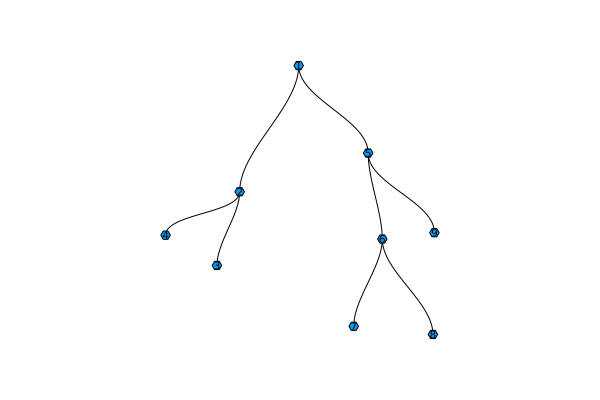

In [9]:
# Main.
instance = "InstancesKnapSack/test.opb.txt"
solveNdisplayKnap(instance)
#println("press enter to exit ! ")
#readline()

## Code 

On compare les performances du Branch-and-Bound entre :
- **Version initiale** (notebook) : séparation lexicographique + exploration depth-first + même borne PSF.
- **Version améliorée** : séparation plus fractionnaire + solution gloutonne initiale (meilleur BestProfit dès le début) + exploration depth-first.

**Mesure** : pour chaque instance, on mesure :
- le nombre de nœuds explorés (taille de l'arbre mémorisé),
- le temps d'exécution (en ms),
- et on vérifie que la valeur optimale trouvée est la même.

**Choix des instances** : ici on utilise des instances de tailles et de natures variées. En pratique, certaines instances plus grandes (500/1000 objets) peuvent ne pas terminer en temps raisonnable avec un Branch and Bound pur. On compare ci-dessous sur plusieurs instances de taille 100 (différents types : Similar/Strongly/Weakly/Uncorrelated).

In [10]:
using Printf

function run_silently(f)
    redirect_stdout(devnull) do
        redirect_stderr(devnull) do
            return f()
        end
    end
end

# ensemble d'instances
instances = [
    "InstancesKnapSack/test.opb.txt",
    "InstancesKnapSack/Similar_Weights/KnapSack_100_1000_-995.opb.txt",
    "InstancesKnapSack/Weakly_Correlated/KnapSack_100_1000_-1514.opb.txt",
    "InstancesKnapSack/Strongly_Correlated/KnapSack_100_1000_-2397.opb.txt",
    "InstancesKnapSack/Uncorrelated/KnapSack_100_1000_-9147.opb.txt",
]


run_silently(() -> solveKnapInstance(instances[1]; use_greedy_init=false, use_mostfractional=false))
run_silently(() -> solveKnapInstance(instances[1]; use_greedy_init=true, use_mostfractional=true))

println("\n=== Comparaison Branch and Bound : initial (init) vs amélioré (am) ===\n")
@printf("%-60s | %6s | %10s | %10s | %10s | %10s | %8s\n", "Instance", "n", "Noeuds init", "ms init", "Noeuds am", "ms am", "speedup")
println(repeat("-", 130))

speedups = Float64[]
for file in instances
    price, weight, cap = readKnaptxtInstance(file)
    n = length(price)

    # Initial 
    t0 = time_ns()
    best0, sol0, p0, c0, names0 = run_silently(() -> solveKnapInstance(file; use_greedy_init=false, use_mostfractional=false))
    dt0 = (time_ns() - t0) / 1e6
    nodes0 = length(names0)

    # Amélioré
    t1 = time_ns()
    best1, sol1, p1, c1, names1 = run_silently(() -> solveKnapInstance(file; use_greedy_init=true, use_mostfractional=true))
    dt1 = (time_ns() - t1) / 1e6
    nodes1 = length(names1)

    sp = dt0 / max(dt1, 1e-9)
    push!(speedups, sp)

    @printf("%-60s | %6d | %10d | %10.2f | %10d | %10.2f | %8.2f\n", file, n, nodes0, dt0, nodes1, dt1, sp)
    if abs(best0 - best1) > 1e-6
        println("  ATTENTION: valeurs différentes (init=", best0, ", am=", best1, ")")
    end
end

println("\nMoyenne speedup (dt_init / dt_am) = ", round(sum(speedups)/length(speedups), digits=2))


=== Comparaison Branch and Bound : initial (init) vs amélioré (am) ===

Instance                                                     |      n | Noeuds init |    ms init |  Noeuds am |      ms am |  speedup
----------------------------------------------------------------------------------------------------------------------------------
InstancesKnapSack/test.opb.txt                               |      4 |         15 |      56.93 |          9 |      41.01 |     1.39
InstancesKnapSack/Similar_Weights/KnapSack_100_1000_-995.opb.txt |    100 |       1113 |     106.48 |        199 |      14.06 |     7.57
InstancesKnapSack/Weakly_Correlated/KnapSack_100_1000_-1514.opb.txt |    100 |      36265 |    2695.74 |        973 |      91.63 |    29.42
InstancesKnapSack/Strongly_Correlated/KnapSack_100_1000_-2397.opb.txt |    100 |      80849 |    3988.50 |       1281 |     106.96 |    37.29
InstancesKnapSack/Uncorrelated/KnapSack_100_1000_-9147.opb.txt |    100 |      17771 |    1147.57 |        745

## Conclusion 

- Sur toutes les instances testées, la version améliorée est plus rapide et explore beaucoup moins de nœuds. Par exemple sur des instances à 100 objets, on passe typiquement de dizaines de milliers de nœuds (≈ 1k–80k) à quelques centaines / ~1k nœuds (≈ 745–1281), ce qui se traduit par des speedups importants (jusqu’à ~38× ici).
- Ces résultats sont cohérents :
  - la solution gloutonne initiale donne très tôt une bonne borne inférieure (BestProfit), ce qui rend le test TO (borne sup ≤ BestProfit) beaucoup plus efficace donc on coupe davantage de branches.
  - la séparation sur la variable « la plus fractionnaire » tend à produire plus vite des sous-problèmes “décisifs”, donc une exploration qui mène plus rapidement à de bonnes solutions et à davantage de coupes.
- La petite instance `test` montre un gain faible (≈1.2×), ce qui est normal : quand l’instance est petite, on ne voit pas vraiment la difference surtout qu'on a un temps aussi pour la compilation Julia.
- Enfin, le fait que certaines instances plus grandes (500/1000) puissent ne pas terminer en temps raisonnable est aussi normal: même avec une bonne borne, le Branch and Bound peut rester exponentiel dans le pire cas. Les optimisations réduisent fortement l’arbre en moyenne, sans garantir un temps borné pour toutes les instances.